In [1]:
import perceval as pcvl
import numpy as np 
from ipywidgets import FloatProgress
import math
import matplotlib.pyplot as plt
from perceval.components.unitary_components import BS, PS
from typing import Union

## Hadamard gate

In [3]:
hadamard = pcvl.BS.H()
hadamard.U

Matrix([
[sqrt(2)/2,  sqrt(2)/2],
[sqrt(2)/2, -sqrt(2)/2]])

## Generic MZI

In [4]:
def mzi(name:str, theta, phi, theta2) -> pcvl.Circuit:
    circ = pcvl.Circuit(2,name=name)
    circ.add(0,BS())
    circ.add(0,PS(theta))
    circ.add(0,BS())
    circ.add(0,PS(phi))
    circ.add(0,PS(theta2))
    circ.add(1,PS(theta2))
    # -np.pi/2 -theta/2

    return circ

## Env

In [10]:
env = mzi("U_E", 2*np.pi, 0, -np.pi/2 - np.pi)
env.U

Matrix([
[              1.22464679914735e-16, I*(3.67394039744206e-16 + 2.0*I)/2],
[I*(3.67394039744206e-16 + 2.0*I)/2,              -1.22464679914735e-16]])

## Preparation

In [7]:
theta_prep = pcvl.P("tp") # np.pi - 2 xi 
theta2_prep = pcvl.P("tp2") # -np.pi/2 - theta_prep/2

prep = mzi("U_p", theta_prep, 0, theta2_prep)

## Reflection

In [8]:
theta_refl = pcvl.P("tr") # np.pi - 4 xi 
theta2_refl = pcvl.P("tr2") # -np.pi/2 - theta_refl/2

refl = mzi("U_r", theta_refl, 0, theta2_refl)

## Classical circuit

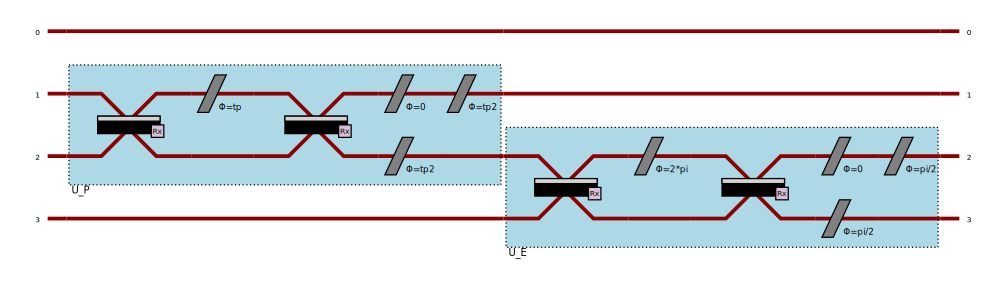

In [11]:
classical_circuit = pcvl.Circuit(4)
classical_circuit.add(1,prep).add(2,env)

pcvl.pdisplay(classical_circuit, recursive=True)

## Quantum circuit

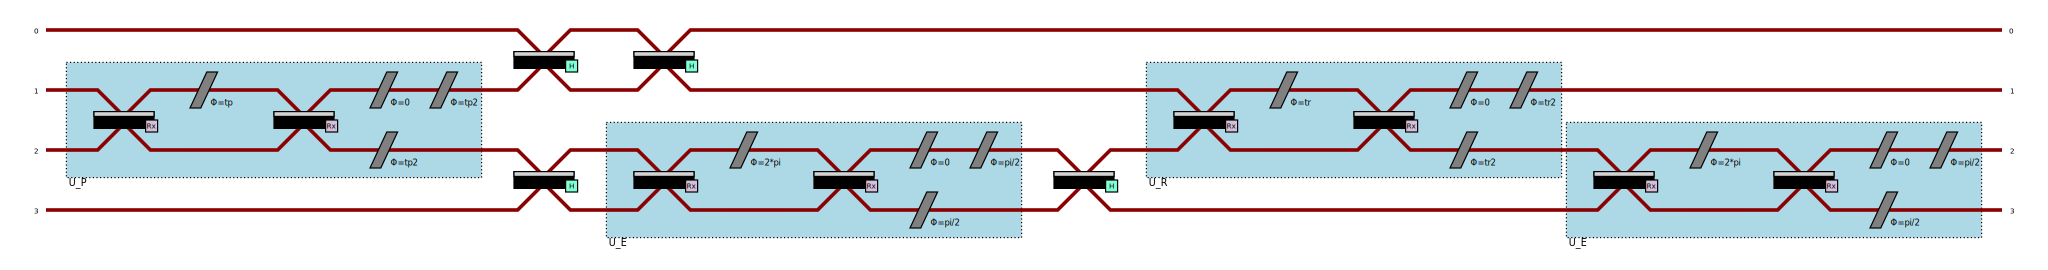

In [12]:
quantum_circuit = pcvl.Circuit(4)
quantum_circuit.add(1,prep)
quantum_circuit.add(0,hadamard)
quantum_circuit.add(2,hadamard)
quantum_circuit.add(2,env)
quantum_circuit.add(0,hadamard)
quantum_circuit.add(2,hadamard)
quantum_circuit.add(1,refl)
quantum_circuit.add(2,env)

pcvl.pdisplay(quantum_circuit, recursive=True)

## Simulation

In [15]:
N_EPOCHS = 1000
N_AGENTS = 100

H_0 = 99
H_1 = 1
EPS0 = H_1 / (H_0+H_1)

## Reward

In [16]:
def get_reward(circuit: pcvl.Circuit) -> bool:

    proc = pcvl.Processor("SLOS", circuit)
    proc.with_input(pcvl.BasicState([0, 1, 0, 0]))

    sampler = pcvl.algorithm.Sampler(proc)
    samples = sampler.samples(1)

    return samples["results"][0] == pcvl.BasicState([0, 0, 0, 1])

## Classical strategy

In [17]:
eta_classical = []

f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent

    # Initialise state 
    h0 = H_0
    h1 = H_1
    eps = EPS0

    xi = np.arcsin(eps**0.5)
    
    theta1 = np.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-np.pi/2 - theta1/2)

    eps_array = []

    for i in range(N_EPOCHS):
        if get_reward(classical_circuit):
            h1 += 2
            eps = h1 / (h0+h1)
            xi = np.arcsin(eps**0.5)

            theta1 = np.pi - 2*xi
            theta_prep.set_value(theta1)
            theta2_prep.set_value(-np.pi/2 - theta1/2)

            eps_array.append(1)
        else:
            eps_array.append(0)

    eta_classical.append(eps_array)

FloatProgress(value=0.0)

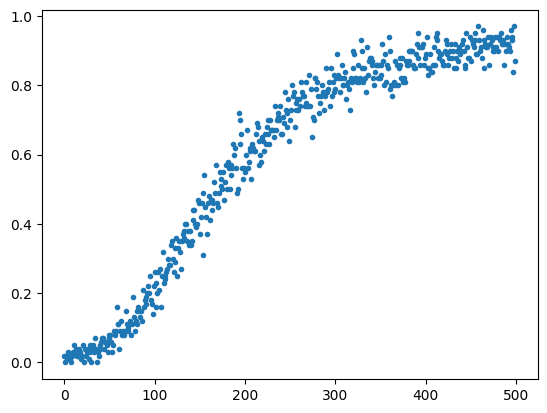

In [22]:
eta_classical = np.array(eta_classical)
plt.plot(np.mean(eta_classical, axis=0)[::2],'.')

## Quantum strategy

In [24]:
eta_quantum = []

f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent

    # Initialise state 
    h0 = H_0
    h1 = H_1
    eps = EPS0

    xi = np.arcsin(eps**0.5)
    
    theta1 = np.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-np.pi/2 - theta1/2)

    theta2 = np.pi - 4*xi
    theta_refl.set_value(theta2)
    theta2_refl.set_value(-np.pi/2 - theta2/2)

    eps_array = []

    for i in range(N_EPOCHS//2):
        if get_reward(quantum_circuit):
            h1 += 2
            eps = h1 / (h0+h1)
            xi = np.arcsin(eps**0.5)

            theta1 = np.pi - 2*xi
            theta_prep.set_value(theta1)
            theta2_prep.set_value(-np.pi/2 - theta1/2)

            theta2 = np.pi - 4*xi
            theta_refl.set_value(theta2)
            theta2_refl.set_value(-np.pi/2 - theta2/2)

            eps_array.append(0.5)
            eps_array.append(0.5)
        else:
            eps_array.append(0)
            eps_array.append(0)

    eta_quantum.append(eps_array)

FloatProgress(value=0.0)

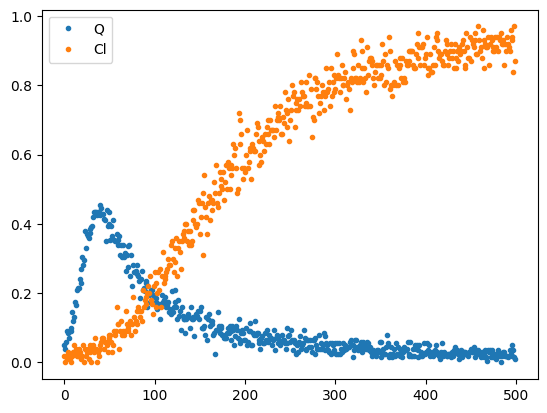

In [30]:
eta_quantum = np.array(eta_quantum)
plt.plot(np.mean(eta_quantum, axis=0)[::2],'.',label='Q')
plt.plot(np.mean(eta_classical, axis=0)[::2],'.',label='Cl')
plt.legend()